# **Face Mask Detection**

### **1. Introduction and Setup**

#### **Overview**
- This notebook implements a COVID Face Mask Detection system using deep learning.
- It leverages transfer learning with MobileNet for efficient feature extraction.

### **Environment Setup**
- Libraries: TensorFlow, OpenCV, Matplotlib, numpy, pandas
- Dataset: Kaggle dataset 'COVID Face Mask Detection Dataset'



In [ ]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

### **Setup Kaggle API**
- Uploaded 'kaggle.json' for dataset download.
- Downloaded and unzipped the dataset.


In [ ]:
files.upload()

{}

In [ ]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [ ]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset
License(s): copyright-authors
 97% 201M/207M [00:03<00:00, 48.3MB/s]
100% 207M/207M [00:03<00:00, 58.4MB/s]


In [ ]:
!unzip \*.zip

Archive:  covid-face-mask-detection-dataset.zip
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Masks Dataset/Test/Mask/2160.png  
  inflating: New Masks Dataset/Test/Mask/2170.png  
  inflating: New Masks Dataset/Test/Mask/2172.png  
  inflating: New Masks Dataset/Test/Mask/2173.png  
  inflating: Ne


### **2. Data Exploration and Preprocessing**

### **Dataset Structure**
- Analyzed the directory structure of the dataset:
  - Training, Testing, and Validation splits.
  - Images categorized into 'Mask' and 'Non Mask' classes.

### **Sample Images**
- Displayed random images from training set to visualize:
  - Example from 'Mask' class
  - Example from 'Non Mask' class


In [ ]:
for dirpath,dirnames,filenames in os.walk("/content/New Masks Dataset"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/New Masks Dataset'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Validation'.
there are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Non Mask'.
there are 0 directories and 153 images in '/content/New Masks Dataset/Validation/Mask'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Test'.
there are 0 directories and 50 images in '/content/New Masks Dataset/Test/Non Mask'.
there are 0 directories and 50 images in '/content/New Masks Dataset/Test/Mask'.
there are 2 directories and 0 images in '/content/New Masks Dataset/Train'.
there are 0 directories and 300 images in '/content/New Masks Dataset/Train/Non Mask'.
there are 0 directories and 300 images in '/content/New Masks Dataset/Train/Mask'.


In [ ]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")

    return img

['295.jpg']
image shape (428, 320, 3)


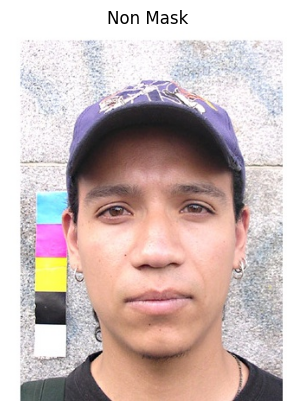

In [ ]:
img = view_image("/content/New Masks Dataset/Train/","Non Mask")

['1040.jpg']
image shape (800, 600, 3)


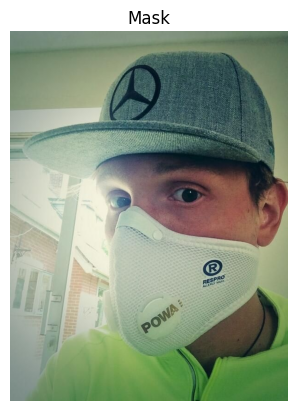

In [ ]:
img = view_image("/content/New Masks Dataset/Train/","Mask")

### **3. Data Loading and Preparation**

### **Loading and Resizing Images**
- Loaded images using OpenCV and resized to 224x224 pixels for uniformity.



In [ ]:
data=[]
labels=[]
no_mask=os.listdir("/content/New Masks Dataset/Train/Non Mask/")
for a in no_mask:

    image = cv2.imread("/content/New Masks Dataset/Train/Non Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [ ]:
mask=os.listdir("/content/New Masks Dataset/Train/Mask/")
for a in mask:

    image = cv2.imread("/content/New Masks Dataset/Train/Mask/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(1)

In [ ]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
data.shape

(600, 224, 224, 3)


### **Data Splitting**
- Split dataset into training and testing sets.
- Stratified sampling to maintain class distribution integrity.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1, random_state=42,shuffle=True,
                                                    stratify = labels)

### **4. Model Building**

### **Transfer Learning with MobileNet**
- Used MobileNet pre-trained on ImageNet without top layers.
- Added custom layers for binary classification (Mask/Non Mask).

### **Model Compilation**
- Optimizer: SGD
- Loss Function: Binary Cross-Entropy
- Metrics: Accuracy


In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights = "imagenet", include_top=False)

base_model.trainable = False

# for layer in base_model.layers[30:]:
#   layer.trainable = False


model = Flatten()(base_model.output)
model = Dense(units=256, activation="relu")(model)
model = Dense(units=64, activation="relu")(model)
prediction_layer = Dense(units=1, activation="sigmoid")(model)

model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step


### **5. Model Training and Evaluation**

### **Training**
- Trained the model for 15 epochs with a batch size of 32.
- Validated on 10% of training data to monitor overfitting.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=15,validation_split= 0.1, batch_size=32)

Epoch 1/15
16/16 [==============================] - 9s 214ms/step - loss: 0.3902 - accuracy: 0.8765 - val_loss: 0.0703 - val_accuracy: 0.9630
Epoch 2/15
16/16 [==============================] - 1s 44ms/step - loss: 0.0116 - accuracy: 0.9979 - val_loss: 0.0665 - val_accuracy: 0.9630
Epoch 3/15
16/16 [==============================] - 1s 49ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0581 - val_accuracy: 0.9630
Epoch 4/15
16/16 [==============================] - 1s 43ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0596 - val_accuracy: 0.9630
Epoch 5/15
16/16 [==============================] - 1s 44ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0639 - val_accuracy: 0.9630
Epoch 6/15
16/16 [==============================] - 1s 49ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0660 - val_accuracy: 0.9630
Epoch 7/15
16/16 [==============================] - 1s 49ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0637 - val_accuracy: 0.9630
Epoch 8/15
1

In [ ]:
predictions = model.predict(X_test)

predict=[]

for i in range(len(predictions)):
    if predictions[i][0]>0.5:
        predict.append(1)
    else:
        predict.append(0)

2/2 [==============================] - 0s 43ms/step



### **Evaluation**
- Evaluated model performance on test set using accuracy and confusion matrix.


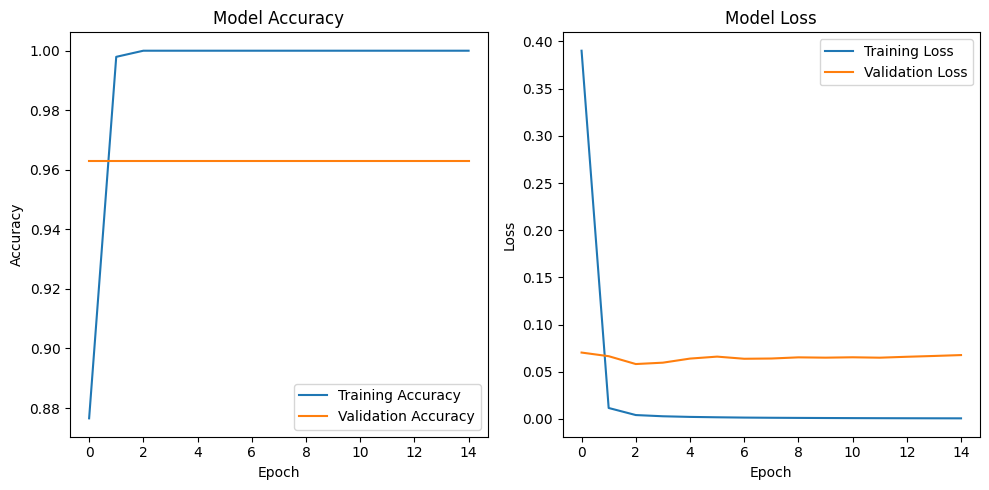

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
pd.DataFrame(confusion_matrix(y_test, predict), columns= ["No Mask", "Mask"], index = ["No Mask", "Mask"])

,No Mask,Mask
No Mask,29,1
Mask,0,30



### **Saving the Model**
- Saved the best performing model as 'mask_detection_best.h5' for deployment.


In [ ]:
model_name = "/content/mask_detection_best.h5"
tf.keras.models.save_model(model, model_name)

<ipython-input-23-0ca11de745e3>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_name)
